In [3]:
datapath = "./mnist_data"

In [4]:
# Downloading MNIST data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from skimage.transform import radon
import torchvision
import os
import pickle
import random
import numpy as np
import gzip
import torchvision.datasets as datasets
from torchvision import transforms
transform = torchvision.transforms.Compose([transforms.ToTensor()])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_trainset = datasets.MNIST(root=datapath, train=True, download=True, transform=transform)
full_testset = datasets.MNIST(root=datapath, train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]


In [5]:
# Sample a small subset of the full training data
random_sampler_train = torch.utils.data.RandomSampler(full_trainset, num_samples=2000)

In [6]:
random_sampler_train = torch.utils.data.RandomSampler(full_testset, num_samples=2000)

In [16]:
# create the forward and the adjoint operators for the 2D blurring kernel (7*7 motion-blur kernel)
### returns the forward operator and the adjoint given a kernel of size p-by-p
def conv2d_block(kernel, channels, p, device, stride=1):
  """
    Returns nn.Conv2d and nn.ConvTranspose2d modules from 2D kernel, such that
    nn.ConvTranspose2d is the adjoint operator of nn.Conv2d
    Arg:
        kernel: 2D kernel, p x p is the kernel size
        channels: number of image channels
    """
  kernel_size = kernel.shape
  kernel = kernel/kernel.sum()
  kernel = kernel.repeat(channels, 1, 1, 1)
  filter = nn.Conv2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=p//2
    )
  filter.weight.data = kernel
  filter.weight.requires_grad = False
  filter_adjoint = nn.ConvTranspose2d(
        in_channels=channels, out_channels=channels,
        kernel_size=kernel_size, groups=channels, bias=False, stride=stride,
        padding=p//2,
    )
  filter_adjoint.weight.data = kernel
  filter_adjoint.weight.requires_grad = False
  return filter.to(device), filter_adjoint.to(device)
  # Motion blur operator
p = 7 #kernel_size
kernel_motion_blur = torch.ones((p, p)).type(torch.FloatTensor).to(device)
#forward, forward_adjoint = conv2d_from_kernel(kernel_motion_blur, channels, device=device) fwd_op, adj_op = conv2d_block(kernel_motion_blur, channels = 1, p = 7, device=device)

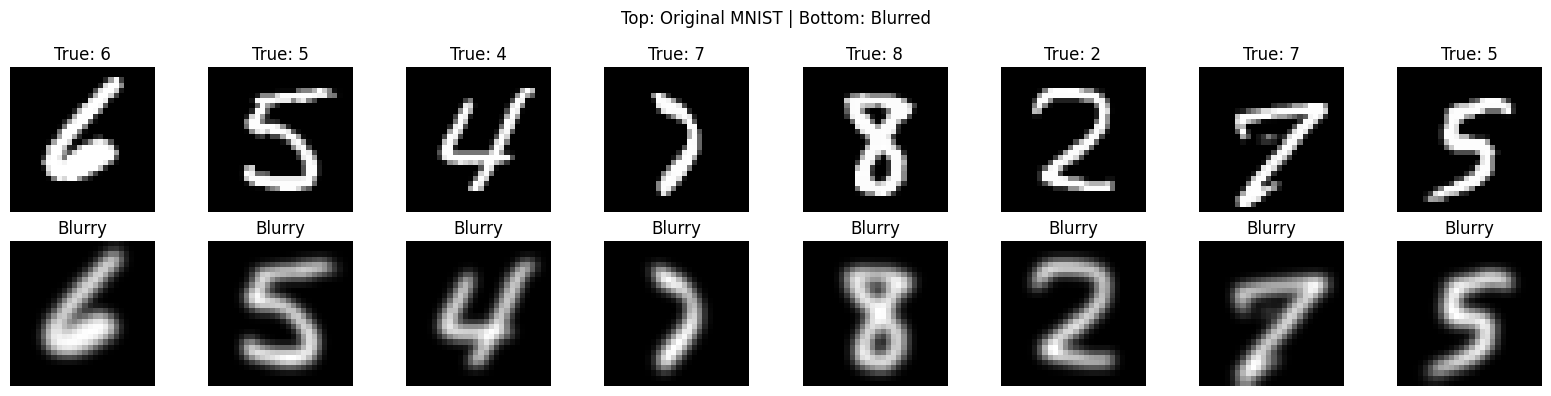

In [17]:
# Display some blurry and some non blurry MNIST images
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF

# Use small DataLoader from existing dataset
small_loader = DataLoader(full_trainset, batch_size=8, shuffle=True)

# Get one batch
images, labels = next(iter(small_loader))

# Apply simple blur (Gaussian) to images
blurred_images = TF.gaussian_blur(images, kernel_size=5)

# Plot original and blurred images
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axs[0, i].imshow(images[i][0], cmap='gray')
    axs[0, i].set_title(f"True: {labels[i].item()}")
    axs[0, i].axis('off')

    axs[1, i].imshow(blurred_images[i][0], cmap='gray')
    axs[1, i].set_title("Blurry")
    axs[1, i].axis('off')

plt.suptitle("Top: Original MNIST | Bottom: Blurred")
plt.tight_layout()
plt.show()


In [41]:
# Train learned primal-dual network, 5 iterations, we implement the primal and dual networks first
class prox_net_dual(nn.Module):
    def __init__(self, n_in_channels=3, n_out_channels=1, n_filters=32, kernel_size=5):
        super(prox_net_dual, self).__init__()
        self.pad = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(n_in_channels, n_filters, kernel_size=kernel_size, padding=self.pad)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, padding=self.pad)
        self.conv3 = nn.Conv2d(n_filters, n_out_channels, kernel_size=kernel_size, padding=self.pad)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()

    def forward(self, h, y, z):
        dh = torch.cat((h, y, z), dim=1)
        dh = self.act1(self.conv1(dh))
        dh = self.act2(self.conv2(dh))
        dh = self.conv3(dh)
        return h + dh

class prox_net_primal(nn.Module):
    def __init__(self, n_in_channels=2, n_out_channels=1, n_filters=32, kernel_size=5):
        super(prox_net_primal, self).__init__()
        self.pad = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(n_in_channels, n_filters, kernel_size=kernel_size, padding=self.pad)
        self.conv2 = nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, padding=self.pad)
        self.conv3 = nn.Conv2d(n_filters, n_out_channels, kernel_size=kernel_size, padding=self.pad)
        self.act1 = nn.PReLU()
        self.act2 = nn.PReLU()

    def forward(self, x, u):
        dx = torch.cat((x, u), dim=1)
        dx = self.act1(self.conv1(dx))
        dx = self.act2(self.conv2(dx))
        dx = self.conv3(dx)
        return x + dx


In [42]:
# Learned primal dual implementation
class LPD(nn.Module):
    def __init__(self, fwd_op, adjoint_op, niter=5, sigma=0.01, tau=0.01):
        super(LPD, self).__init__()
        self.fwd_op = fwd_op
        self.adj_op = adjoint_op
        self.niter = niter
        self.sigma = nn.Parameter(sigma * torch.ones(self.niter).to(device))
        self.tau = nn.Parameter(tau * torch.ones(self.niter).to(device))

        # Make sure each iteration has its own separate learnable networks
        self.cnn_image_layers = nn.ModuleList([prox_net_primal() for _ in range(self.niter)])
        self.cnn_data_layers = nn.ModuleList([prox_net_dual() for _ in range(self.niter)])

    def forward(self, y, x_init):
        x = x_init
        h = torch.zeros_like(y)
        for k in range(self.niter):
            u = self.fwd_op(x)
            z = h + self.sigma[k] * (u - y)
            h = self.cnn_data_layers[k](h, y, z)

            v = self.adj_op(h)
            x = self.cnn_image_layers[k](x, v)
        return x



In [43]:
# model training
from torch.utils.data import Subset

# Use small subsets for faster training
train_subset = Subset(full_trainset, list(range(1000)))  # First 1,000 samples
test_subset = Subset(full_testset, list(range(200)))     # First 200 samples

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)


In [48]:
import torch.nn.functional as F

def gaussian_blur(x, kernel_size=5, sigma=1.0):
    # Apply blur per image in batch
    blurred = torch.stack([TF.gaussian_blur(img, kernel_size=kernel_size, sigma=sigma) for img in x])
    return blurred


class ForwardOp:
    def __call__(self, x):
        return gaussian_blur(x)

class AdjointOp:
    def __call__(self, y):
        # For symmetric kernels, forward == adjoint (approx)
        return gaussian_blur(y)


In [49]:
fwd_op = ForwardOp()
adj_op = AdjointOp()
model = LPD(fwd_op, adj_op, niter=5).to(device)


In [50]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [51]:
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        imgs, _ = batch
        imgs = imgs.to(device)

        # Apply blur to create y (observation)
        y = fwd_op(imgs)

        # Initialize x (reconstruction guess)
        x_init = torch.zeros_like(imgs)

        # Forward pass
        output = model(y, x_init)

        loss = criterion(output, imgs)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}")


Epoch 1, Training Loss: 0.0378
Epoch 2, Training Loss: 0.0072
Epoch 3, Training Loss: 0.0043
Epoch 4, Training Loss: 0.0032
Epoch 5, Training Loss: 0.0026


In [52]:
model.eval()
mse_total = 0.0
with torch.no_grad():
    for batch in test_loader:
        imgs, _ = batch
        imgs = imgs.to(device)

        y = fwd_op(imgs)
        x_init = torch.zeros_like(imgs)
        output = model(y, x_init)

        mse_total += criterion(output, imgs).item()

avg_mse = mse_total / len(test_loader)
print(f"Test MSE: {avg_mse:.4f}")


Test MSE: 0.0023
